# Train a mobilenet model using Tensorflow

The ```setup.ipynb``` notebook must first be run to setup the workspace, datasets, and libraries that are used in this notebook.

## Examine the dataset

Let's look at the data in the dataset. The Oxford IIIT Pets dataset contains pictures of 37 different species of dogs and cats. All of that data lives in the ```images``` directory of this project. Let's begin by looking at the contents of this directory.

You can see that the name of each directory is the name of the breed. Within each directory is ~200 photos of that breed.

In [2]:
!ls images

Abyssinian		   Egyptian_Mau		   pug
Abyssinian_100.mat	   english_cocker_spaniel  Ragdoll
Abyssinian_101.mat	   english_setter	   Russian_Blue
Abyssinian_102.mat	   german_shorthaired	   saint_bernard
american_bulldog	   great_pyrenees	   samoyed
american_pit_bull_terrier  havanese		   scottish_terrier
basset_hound		   japanese_chin	   shiba_inu
beagle			   keeshond		   Siamese
Bengal			   leonberger		   Sphynx
Birman			   Maine_Coon		   staffordshire_bull_terrier
Bombay			   miniature_pinscher	   wheaten_terrier
boxer			   newfoundland		   yorkshire_terrier
British_Shorthair	   Persian
chihuahua		   pomeranian


Let's look at some sample images for each breed. We're using some code in the ```image_helpers``` module to render and display thumbnails of each image using ```matplotlib```.

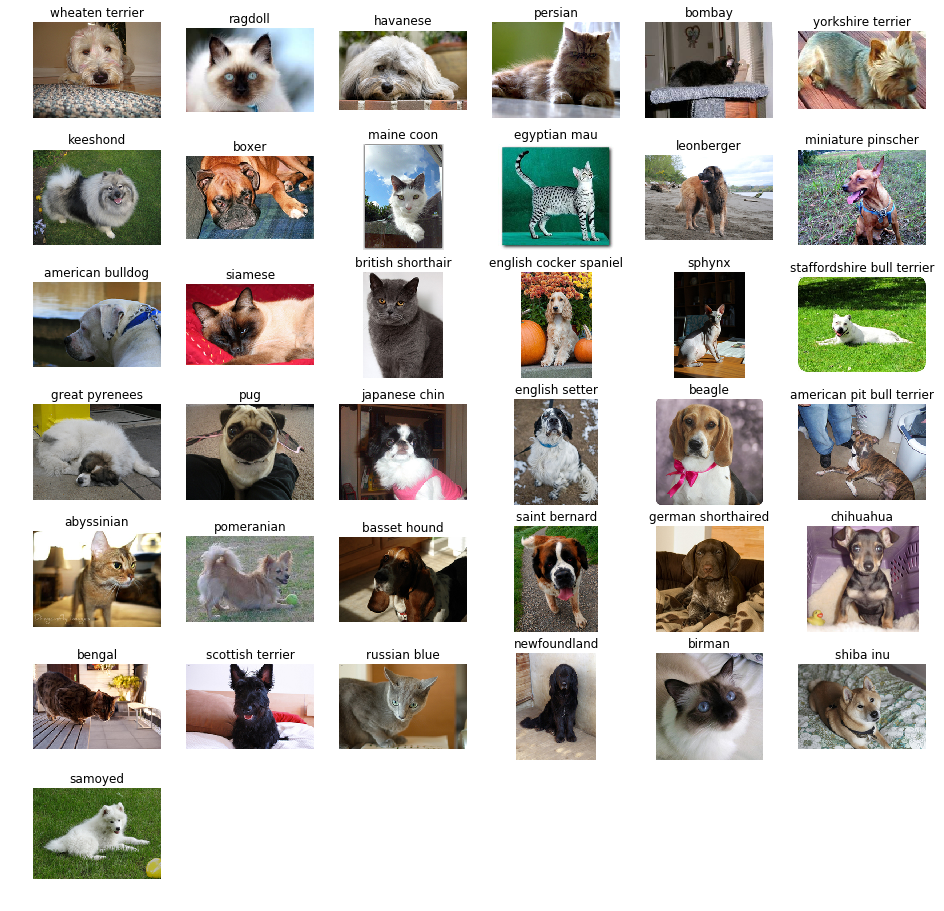

In [3]:
%matplotlib inline
from scripts.image_helpers import get_sample_images_for_each_species, plot_images_in_grid

images_data = get_sample_images_for_each_species('images')
plot_images_in_grid(images_data, 6)

## Transfer learning using mobilenet and our pet images

Next, let's use transfer learning to retrain the final layer of the `mobilenet` model. We'll be using the images that we saw earlier to train this model.

Get a reference to the ```Workspace``` and the ```Experiment``` that we will be using in this demo.

In [1]:
from scripts.config import AML
from azureml.core import Workspace
from azureml.core import Experiment

ws = Workspace.get(name=AML.workspace_name, 
                   subscription_id=AML.subscription_id, 
                   resource_group=AML.resource_group) 

experiment = Experiment(ws, AML.experiment_name)

In [5]:
from scripts.retrain import train

train(architecture='mobilenet_0.50_224', 
      image_dir='images', 
      output_dir='models', 
      bottleneck_dir='bottleneck',
      model_dir='model',
      learning_rate=0.00008, 
      use_hyperdrive=False)

INFO:tensorflow:Looking for images in 'Abyssinian'
INFO:tensorflow:Looking for images in 'Bengal'
INFO:tensorflow:Looking for images in 'Birman'
INFO:tensorflow:Looking for images in 'Bombay'
INFO:tensorflow:Looking for images in 'British_Shorthair'
INFO:tensorflow:Looking for images in 'Egyptian_Mau'
INFO:tensorflow:Looking for images in 'Maine_Coon'
INFO:tensorflow:Looking for images in 'Persian'
INFO:tensorflow:Looking for images in 'Ragdoll'
INFO:tensorflow:Looking for images in 'Russian_Blue'
INFO:tensorflow:Looking for images in 'Siamese'
INFO:tensorflow:Looking for images in 'Sphynx'
INFO:tensorflow:Looking for images in 'american_bulldog'
INFO:tensorflow:Looking for images in 'american_pit_bull_terrier'
INFO:tensorflow:Looking for images in 'basset_hound'
INFO:tensorflow:Looking for images in 'beagle'
INFO:tensorflow:Looking for images in 'boxer'
INFO:tensorflow:Looking for images in 'chihuahua'
INFO:tensorflow:Looking for images in 'english_cocker_spaniel'
INFO:tensorflow:Look

INFO:tensorflow:2018-11-10 19:27:27.308932: Step 100: Train accuracy = 59.0%
INFO:tensorflow:2018-11-10 19:27:27.309658: Step 100: Cross entropy = 2.996008
INFO:tensorflow:2018-11-10 19:27:27.346820: Step 100: Validation accuracy = 59.0% (N=100)
INFO:tensorflow:2018-11-10 19:27:27.733598: Step 110: Train accuracy = 58.0%
INFO:tensorflow:2018-11-10 19:27:27.734348: Step 110: Cross entropy = 2.981486
INFO:tensorflow:2018-11-10 19:27:27.772688: Step 110: Validation accuracy = 63.0% (N=100)
INFO:tensorflow:2018-11-10 19:27:28.142161: Step 120: Train accuracy = 67.0%
INFO:tensorflow:2018-11-10 19:27:28.142867: Step 120: Cross entropy = 2.878640
INFO:tensorflow:2018-11-10 19:27:28.180891: Step 120: Validation accuracy = 67.0% (N=100)
INFO:tensorflow:2018-11-10 19:27:28.559952: Step 130: Train accuracy = 72.0%
INFO:tensorflow:2018-11-10 19:27:28.560678: Step 130: Cross entropy = 2.866022
INFO:tensorflow:2018-11-10 19:27:28.598829: Step 130: Validation accuracy = 73.0% (N=100)
INFO:tensorflow:

INFO:tensorflow:2018-11-10 19:27:41.084371: Step 430: Cross entropy = 1.986907
INFO:tensorflow:2018-11-10 19:27:41.122530: Step 430: Validation accuracy = 77.0% (N=100)
INFO:tensorflow:2018-11-10 19:27:41.495413: Step 440: Train accuracy = 73.0%
INFO:tensorflow:2018-11-10 19:27:41.496159: Step 440: Cross entropy = 2.046453
INFO:tensorflow:2018-11-10 19:27:41.535080: Step 440: Validation accuracy = 79.0% (N=100)
INFO:tensorflow:2018-11-10 19:27:41.915722: Step 450: Train accuracy = 75.0%
INFO:tensorflow:2018-11-10 19:27:41.916469: Step 450: Cross entropy = 2.015300
INFO:tensorflow:2018-11-10 19:27:41.956018: Step 450: Validation accuracy = 79.0% (N=100)
INFO:tensorflow:2018-11-10 19:27:42.344464: Step 460: Train accuracy = 79.0%
INFO:tensorflow:2018-11-10 19:27:42.345230: Step 460: Cross entropy = 1.934183
INFO:tensorflow:2018-11-10 19:27:42.385562: Step 460: Validation accuracy = 80.0% (N=100)
INFO:tensorflow:2018-11-10 19:27:42.789892: Step 470: Train accuracy = 70.0%
INFO:tensorflow:

The validation accuracy of this model isn't bad, with a **validation accuracy of 79%** using a learning rate of 0.00008. Let's see if we can optimize this model using the Hyperdrive feature of Azure Machine Learning to explore different learning rates by doing many runs using an Azure Batch AI cluster of GPU equipped VMs.

## Using HyperDrive to do hyper parameter optimization

Now that we have a model, the next step is to tune it for hyperdrive parameters. Hyperdrive works by copying a training script to each node in the cluster. We will be using an Azure ML `Datastore` that contains the all of the images that we used locally in this DSVM. 

Below is our training script:

In [6]:
%%writefile scripts/train.py

import argparse, os
import retrain as rt

parser = argparse.ArgumentParser()
parser.add_argument('--datastore-dir', type=str, dest='datastore_dir', help='datastore dir mounting point')
parser.add_argument('--learning-rate', type=float, dest='learning_rate', default=0.01, help='learning rate')
args = parser.parse_args()

images_dir = os.path.join(args.datastore_dir, 'images')
bottleneck_dir = os.path.join(args.datastore_dir, 'bottleneck')
model_dir = os.path.join(args.datastore_dir, 'model')
output_dir = 'outputs'

rt.train(architecture='mobilenet_0.50_224', 
         image_dir=images_dir,
         output_dir=output_dir,
         bottleneck_dir=bottleneck_dir,
         model_dir=model_dir,
         learning_rate=args.learning_rate,
         use_hyperdrive=True)

Writing scripts/train.py


## Let's put a diagram here to explain this

Now let's create and submit a Hyperdrive job. There are two key things to point out here:

1. We are doing a random sampling of the learning rate, varying it from 10E-15 to 10E-3, using a logarithmic random number generator.
1. We are point to a ```Datastore``` that we have configured earlier with the Oxford IIIT training dataset passed in by reference to each node on the compute store.
1. We are passing the ```train.py``` file that we wrote out earlier to each compute node on the Batch AI cluster.
1. The training code writes out ```validation_accuracy``` to a logfile that is read by the Hyperdrive daemon to determine whether to prematurely terminate some runs if they are not within 15% of the best run to date.


Run the next cell to kick off a hyperdrive run. A full run takes ~22 minutes to complete.Run the cell after that to look at data that came from an older run.

In [7]:
from azureml.train.dnn import TensorFlow
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveRunConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import loguniform, uniform

cluster = ws.compute_targets[AML.compute_name]

script_params={
    '--datastore-dir': ws.get_default_datastore().as_mount(),
}

tf_estimator = TensorFlow(source_directory='scripts',
                          compute_target=cluster,
                          entry_script='train.py',
                          script_params=script_params,
                          use_gpu=True)

ps = RandomParameterSampling(
    {
        '--learning-rate': loguniform(-15, -3)
    }
)

early_termination_policy = BanditPolicy(slack_factor = 0.15, evaluation_interval=2)

hyperdrive_run_config = HyperDriveRunConfig(estimator = tf_estimator, 
                                            hyperparameter_sampling = ps, 
                                            policy = early_termination_policy,
                                            primary_metric_name = "validation_accuracy",
                                            primary_metric_goal = PrimaryMetricGoal.MAXIMIZE,
                                            max_total_runs = 20,
                                            max_concurrent_runs = 4)

hd_run = experiment.submit(hyperdrive_run_config)
hd_run_id = hd_run.id
hd_run_id

'ConnectExperiment_1541878094718'

In [8]:
# hd_run_id = 'ConnectExperiment_1541806587666' <- first failed run
hd_run_id = 'ConnectExperiment_1541878094718'

Show progress using the AML Widget.

In [9]:
from azureml.core import Run
from azureml.train.widgets import RunDetails

RunDetails(Run(experiment, hd_run_id)).show()

_HyperDrive(widget_settings={'childWidgetDisplay': 'popup'})

_UserRun(widget_settings={'childWidgetDisplay': 'popup', 'display': 'popup'})

_UserRun(widget_settings={'childWidgetDisplay': 'popup', 'display': 'popup'})

## Retrieve the best run from the Hyperdrive run

In [15]:
best_run = hd_run.get_best_run_by_primary_metric()
model = best_run.register_model(model_name='pet-detector', model_path='outputs')